In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
!git clone https://github.com/ArashSameni/rfml

fatal: destination path 'rfml' already exists and is not an empty directory.


In [60]:
!pip install --user -e ./rfml

Obtaining file:///content/rfml
  Preparing metadata (setup.py) ... done
  Attempting uninstall: rfml
    Found existing installation: rfml 1.0.0
    Uninstalling rfml-1.0.0:
      Successfully uninstalled rfml-1.0.0
  Running setup.py develop for rfml


In [28]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Internal Includes
from rfml.nn.model import Model
from rfml.data import Dataset, Encoder
from rfml.data.converters import load_RML201610A_dataset
from rfml.nn.train import StandardTrainingStrategy, PrintingTrainingListener
from rfml.nbutils import plot_acc_vs_snr, plot_confusion, plot_IQ
from rfml.nn.eval import compute_accuracy, compute_accuracy_on_cross_sections, compute_confusion
from pandas import DataFrame

from typing import List
from pprint import pprint

In [2]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
fig_dir = None   # Set to a file path if you'd like to save the plots generated
data_path = './RML2016.10a_dict.pkl' # Set to a file path if you've downloaded RML2016.10A locally

In [4]:
dataset = load_RML201610A_dataset(path=data_path)
print(f'Dataset size: {len(dataset)}')
pprint(dataset.get_examples_per_class())

Dataset size: 220000
{'8PSK': 20000,
 'AM-DSB': 20000,
 'AM-SSB': 20000,
 'BPSK': 20000,
 'CPFSK': 20000,
 'GFSK': 20000,
 'PAM4': 20000,
 'QAM16': 20000,
 'QAM64': 20000,
 'QPSK': 20000,
 'WBFM': 20000}


In [5]:
print(f'Modulations: {dataset.metadata["Modulation"]}')
print(f'SNRs: {dataset.metadata["SNR"]}')

Modulations: {'CPFSK', 'QAM16', '8PSK', 'WBFM', 'AM-SSB', 'BPSK', 'PAM4', 'QAM64', 'GFSK', 'QPSK', 'AM-DSB'}
SNRs: {0, 2, 4, 6, 8, 10, 12, 14, 16, 18, -20, -18, -16, -14, -12, -10, -8, -6, -4, -2}


In [6]:
train, test = dataset.split(frac=0.5, on=["Modulation", "SNR"])

print("Training Examples")
print("=================")
pprint(train.get_examples_per_class())
print("=================")
print()
print("Testing Examples")
print("=================")
pprint(test.get_examples_per_class())
print("=================")

Training Examples
{'8PSK': 10000,
 'AM-DSB': 10000,
 'AM-SSB': 10000,
 'BPSK': 10000,
 'CPFSK': 10000,
 'GFSK': 10000,
 'PAM4': 10000,
 'QAM16': 10000,
 'QAM64': 10000,
 'QPSK': 10000,
 'WBFM': 10000}

Testing Examples
{'8PSK': 10000,
 'AM-DSB': 10000,
 'AM-SSB': 10000,
 'BPSK': 10000,
 'CPFSK': 10000,
 'GFSK': 10000,
 'PAM4': 10000,
 'QAM16': 10000,
 'QAM64': 10000,
 'QPSK': 10000,
 'WBFM': 10000}


In [7]:
le = Encoder([
    '8PSK',
    'AM-DSB',
    'AM-SSB',
    'BPSK',
    'CPFSK',
    'GFSK',
    'PAM4',
    'QAM16',
    'QAM64',
    'QPSK',
    'WBFM'], label_name="Modulation")
print(le)

8PSK: 0
AM-DSB: 1
AM-SSB: 2
BPSK: 3
CPFSK: 4
GFSK: 5
PAM4: 6
QAM16: 7
QAM64: 8
QPSK: 9
WBFM: 10



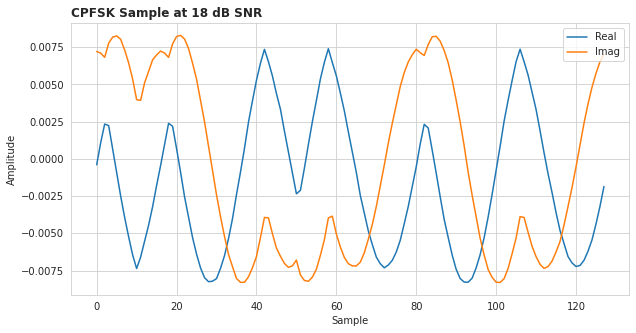

In [8]:
# Plot a sample of the data
# You can choose a different sample by changing
idx = 10
snr = 18
modulation = "CPFSK"

mask = (dataset.df["SNR"] == snr) & (dataset.df["Modulation"] == modulation)
sample = dataset.as_numpy(mask=mask, le=le)[0][idx,0,:]
t = np.arange(sample.shape[1])

title = "{modulation} Sample at {snr:.0f} dB SNR".format(modulation=modulation, snr=snr)
fig = plot_IQ(iq=sample, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/{modulation}_{snr:.0f}dB_sample.pdf".format(fig_dir=fig_dir,
                                                                       modulation=modulation,
                                                                       snr=snr)
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

In [9]:
class VT_CNN2(Model):
    def __init__(
        self,
        n_classes: int = 11,
        dropout: float = 0.5,
    ):
        super().__init__(input_samples=128, n_classes=n_classes)

        self.model = nn.Sequential(
            nn.ZeroPad2d(
                padding=(
                    2,
                    2,
                    0,
                    0,
                )
            ),  # zero pad front/back of each signal by 2
            nn.Conv2d(
                in_channels=1, out_channels=256, kernel_size=(1, 3), stride=1, padding=0, bias=False
            ),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.ZeroPad2d(
                padding=(
                    2,
                    2,
                    0,
                    0,
                )
            ),  # zero pad front/back of each signal by 2
            nn.Conv2d(
                in_channels=256,
                out_channels=80,
                kernel_size=(2, 3),
                stride=1,
                padding=0,
            ),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Flatten(),
            nn.Linear(in_features=10560, out_features=256, bias=True),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=256, out_features=n_classes, bias=True),
        )

    def forward(self, x):
        return self.model(x)

In [10]:
model = VT_CNN2()
if torch.cuda.is_available():
  model.cuda()

# Print model summary
print(model)

learnable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of Learnable Parameters: {learnable_params}')

VT_CNN2(
  (model): Sequential(
    (0): ZeroPad2d((2, 2, 0, 0))
    (1): Conv2d(1, 256, kernel_size=(1, 3), stride=(1, 1), bias=False)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): ZeroPad2d((2, 2, 0, 0))
    (5): Conv2d(256, 80, kernel_size=(2, 3), stride=(1, 1))
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=10560, out_features=256, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=256, out_features=11, bias=True)
  )
)
----------------------
Trainable Parameters: 2830171
Fixed Parameters: 0
Total Parameters: 2830171
----------------------

Number of Learnable Parameters: 2830171


In [11]:
lr = 1e-3           # learning rate
max_epochs = 100    # number of epochs to train on
batch_size = 1024   # training batch size
n_classes = 11      # number of classes
patience = 5        # patience of early stopping

training_listener = PrintingTrainingListener()

In [12]:
trainer = StandardTrainingStrategy(lr, max_epochs, patience, batch_size, gpu=True)
trainer.register_listener(training_listener)

In [40]:
trainer(model=model,
                               training=train,
                               validation=test,
                               le=le)
model.save('./drive/MyDrive/VTCNN2_100Epochs.pt')

Epoch 0 completed!
		-Mean Training Loss: 2.131
		-Mean Validation Loss: 1.935
Epoch 1 completed!
		-Mean Training Loss: 1.899
		-Mean Validation Loss: 1.782
Epoch 2 completed!
		-Mean Training Loss: 1.766
		-Mean Validation Loss: 1.646
Epoch 3 completed!
		-Mean Training Loss: 1.675
		-Mean Validation Loss: 1.558
Epoch 4 completed!
		-Mean Training Loss: 1.609
		-Mean Validation Loss: 1.502
Epoch 5 completed!
		-Mean Training Loss: 1.553
		-Mean Validation Loss: 1.442
Epoch 6 completed!
		-Mean Training Loss: 1.514
		-Mean Validation Loss: 1.409
Epoch 7 completed!
		-Mean Training Loss: 1.483
		-Mean Validation Loss: 1.380
Epoch 8 completed!
		-Mean Training Loss: 1.461
		-Mean Validation Loss: 1.363
Epoch 9 completed!
		-Mean Training Loss: 1.441
		-Mean Validation Loss: 1.344
Epoch 10 completed!
		-Mean Training Loss: 1.422
		-Mean Validation Loss: 1.345
Epoch 11 completed!
		-Mean Training Loss: 1.411
		-Mean Validation Loss: 1.324
Epoch 12 completed!
		-Mean Training Loss: 1.397
	

TypeError: cannot unpack non-iterable NoneType object

In [13]:
model.load('./VTCNN2_100Epochs.pt')

In [16]:
acc = compute_accuracy(model=model, data=test, le=le)
print("Overall Testing Accuracy: {:.2f}%".format(acc * 100))

Overall Testing Accuracy: 54.05%


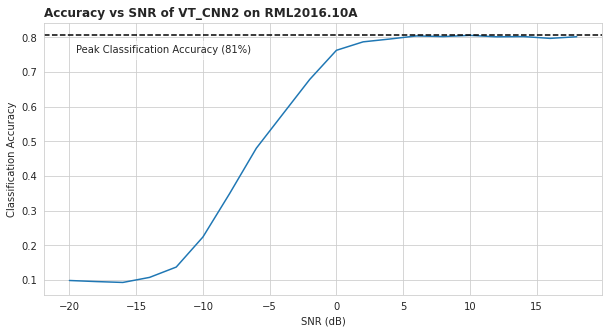


SNR: -20, Overall Accuracy: 9.91%
SNR: -18, Overall Accuracy: 9.60%
SNR: -16, Overall Accuracy: 9.35%
SNR: -14, Overall Accuracy: 10.80%
SNR: -12, Overall Accuracy: 13.78%
SNR: -10, Overall Accuracy: 22.45%
SNR: -8, Overall Accuracy: 34.98%
SNR: -6, Overall Accuracy: 48.05%
SNR: -4, Overall Accuracy: 57.98%
SNR: -2, Overall Accuracy: 67.89%
SNR: 0, Overall Accuracy: 76.29%
SNR: 2, Overall Accuracy: 78.73%
SNR: 4, Overall Accuracy: 79.55%
SNR: 6, Overall Accuracy: 80.44%
SNR: 8, Overall Accuracy: 80.25%
SNR: 10, Overall Accuracy: 80.60%
SNR: 12, Overall Accuracy: 80.18%
SNR: 14, Overall Accuracy: 80.25%
SNR: 16, Overall Accuracy: 79.73%
SNR: 18, Overall Accuracy: 80.20%


In [17]:
acc_vs_snr, snr = compute_accuracy_on_cross_sections(model=model,
                                                     data=test,
                                                     le=le,
                                                     column="SNR")

title = "Accuracy vs SNR of {model_name} on {dataset_name}".format(model_name="VT_CNN2", dataset_name="RML2016.10A")
fig = plot_acc_vs_snr(acc_vs_snr=acc_vs_snr, snr=snr, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/acc_vs_snr.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

print()
for idx in np.argsort(snr):
    print("SNR: {}, Overall Accuracy: {:.2f}%".format(snr[idx], acc_vs_snr[idx] * 100))

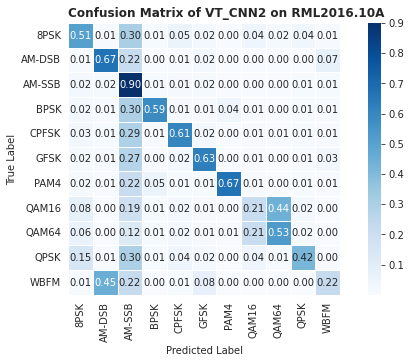

In [18]:
cmn = compute_confusion(model=model, data=test, le=le)

title = "Confusion Matrix of {model_name} on {dataset_name}".format(model_name="VT_CNN2", dataset_name="RML2016.10A")
fig = plot_confusion(cm=cmn, labels=le.labels, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/confusion_matrix.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

# Attacks

In [ ]:
!pip install torchattacks

In [22]:
import torchattacks

In [55]:
pgd_atk = torchattacks.PGD(model, eps=8/255, alpha=2/225, steps=10, random_start=True)
fgsm_atk = fgsm_atk = torchattacks.FGSM(model, eps=8/255)
deepfool_atk = torchattacks.DeepFool(model, steps=50, overshoot=0.02)

In [63]:
def compute_accuracy_after_atks(
    model: Model,
    data: Dataset,
    le: Encoder,
    atks: List[torchattacks.attack.Attack],
    batch_size: int = 512,
    mask: DataFrame.mask = None
):
    dl = DataLoader(
        data.as_torch(le=le, mask=mask), shuffle=True, batch_size=batch_size
    )

    total = 0
    corrects = {atk.__class__.__name__: 0 for atk in atks}
    corrects[model.__class__.__name__] = 0

    for batch, data in enumerate(dl):
        inputs, labels = data
        
        predictions = model.predict(inputs)
        corrects[model.__class__.__name__] += (predictions == labels).sum().item()
        total += len(labels)

        for atk in atks:
            adv_inputs = atk(inputs, labels)
            adv_predictions = model.predict(adv_inputs)
            corrects[atk.__class__.__name__] += (adv_predictions == labels).sum().item()
        
        print(f'Batch: {batch}, Total: {total}, Corrects: {corrects}')
        
    accuracies = {k: float(corrects[k]) / total for k in corrects}
    
    return accuracies

In [76]:
atks = [pgd_atk, fgsm_atk, deepfool_atk]
mask = (dataset.df["SNR"] == 18)
accuracies = compute_accuracy_after_atks(model, test, le, atks, mask=mask)

/home/u111187/sameni/rfml/rfml/data/dataset.py:237: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[mask]


Batch: 0, Total: 512, Corrects: {'PGD': 0, 'FGSM': 38, 'DeepFool': 8, 'VT_CNN2': 401}
Batch: 1, Total: 1024, Corrects: {'PGD': 0, 'FGSM': 76, 'DeepFool': 13, 'VT_CNN2': 808}
Batch: 2, Total: 1536, Corrects: {'PGD': 0, 'FGSM': 110, 'DeepFool': 16, 'VT_CNN2': 1221}
Batch: 3, Total: 2048, Corrects: {'PGD': 0, 'FGSM': 148, 'DeepFool': 22, 'VT_CNN2': 1643}
Batch: 4, Total: 2560, Corrects: {'PGD': 0, 'FGSM': 187, 'DeepFool': 25, 'VT_CNN2': 2048}
Batch: 5, Total: 3072, Corrects: {'PGD': 0, 'FGSM': 231, 'DeepFool': 28, 'VT_CNN2': 2471}
Batch: 6, Total: 3584, Corrects: {'PGD': 0, 'FGSM': 276, 'DeepFool': 34, 'VT_CNN2': 2881}
Batch: 7, Total: 4096, Corrects: {'PGD': 0, 'FGSM': 314, 'DeepFool': 37, 'VT_CNN2': 3297}
Batch: 8, Total: 4608, Corrects: {'PGD': 0, 'FGSM': 358, 'DeepFool': 46, 'VT_CNN2': 3691}
Batch: 9, Total: 5120, Corrects: {'PGD': 0, 'FGSM': 408, 'DeepFool': 51, 'VT_CNN2': 4109}
Batch: 10, Total: 5500, Corrects: {'PGD': 0, 'FGSM': 441, 'DeepFool': 53, 'VT_CNN2': 4411}


In [77]:
for k in accuracies:
    print(f'{k}: {accuracies[k] * 100}%')

PGD: 0.0%
FGSM: 8.01818181818182%
DeepFool: 0.9636363636363635%
VT_CNN2: 80.2%
